final temperature =  0.8039635509270133 T0
The eigenvalues are:
lambda = 1.49780
lambda = 2.57508
lambda = 3.63471
lambda = 4.68873
lambda = 5.74025
lambda = 6.79043
lambda = 7.83982
lambda = 8.88868
lambda = 9.93720
lambda = 10.98546
lambda = 12.03354
lambda = 13.08148
lambda = 14.12930
lambda = 15.17704
lambda = 16.22471
lambda = 17.27233
lambda = 18.31989
lambda = 19.36742


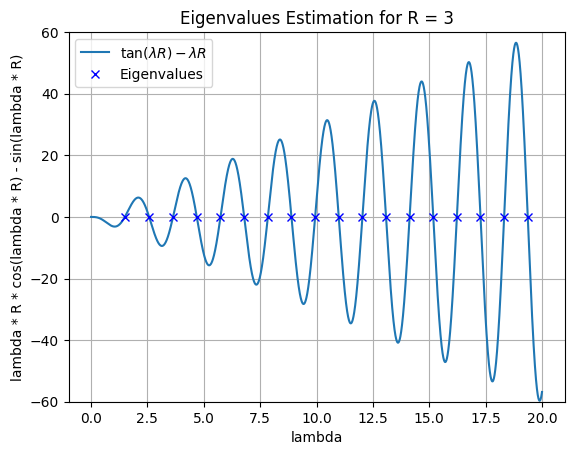

[18, 7, 6, 4, 3, 2, 2, 1, 1]


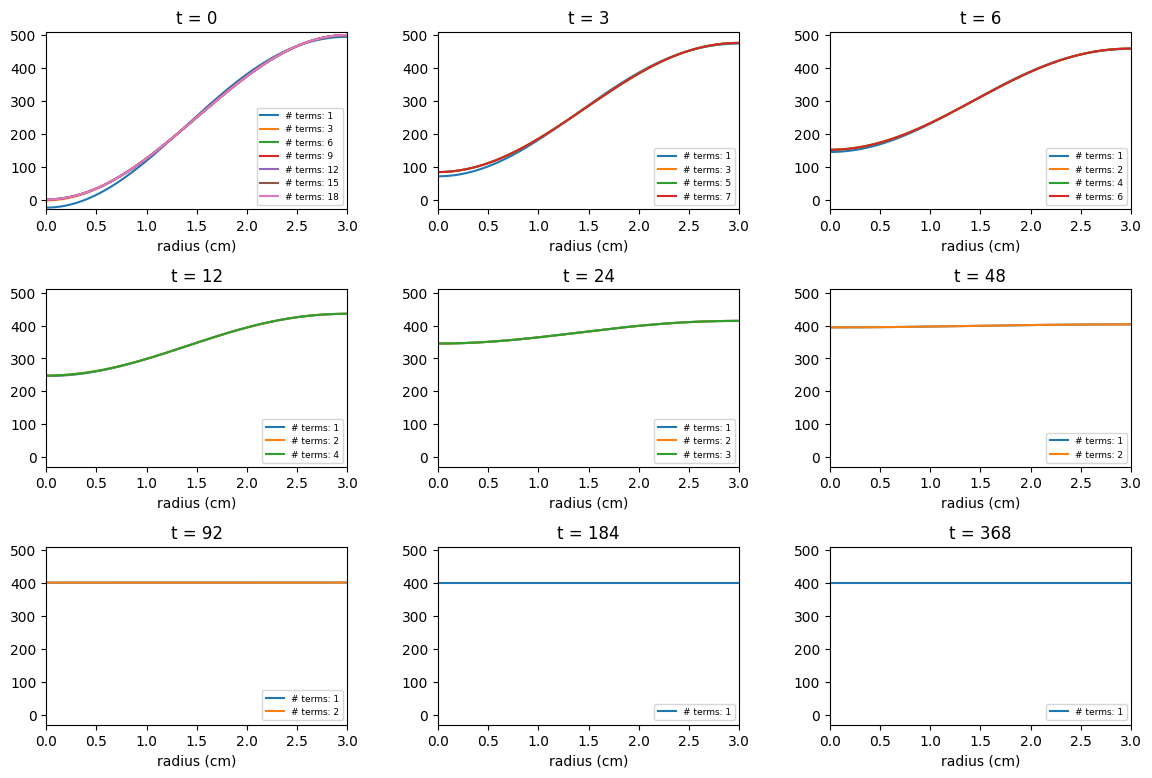

   Time  Eigenvalues
0     0           18
1     3            7
2     6            6
3    12            4
4    24            3
5    48            2
6    92            2
7   184            1
8   368            1


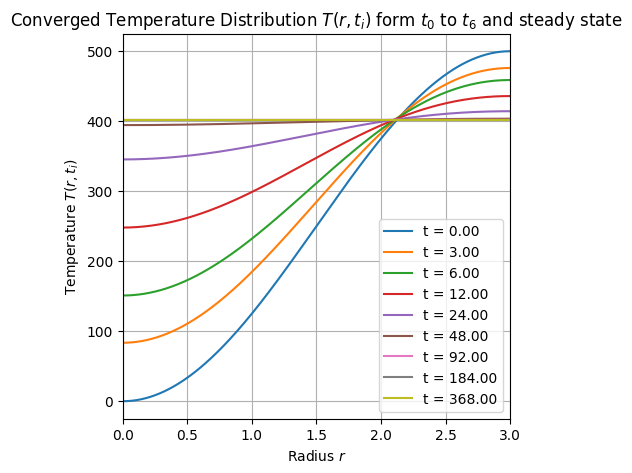

    Eigenvalues
0       1.49780
1       2.57508
2       3.63471
3       4.68873
4       5.74025
5       6.79043
6       7.83982
7       8.88868
8       9.93720
9      10.98546
10     12.03354
11     13.08148
12     14.12930
13     15.17704
14     16.22471
15     17.27233
16     18.31989
17     19.36742


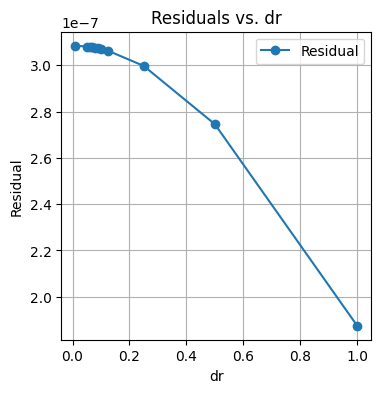

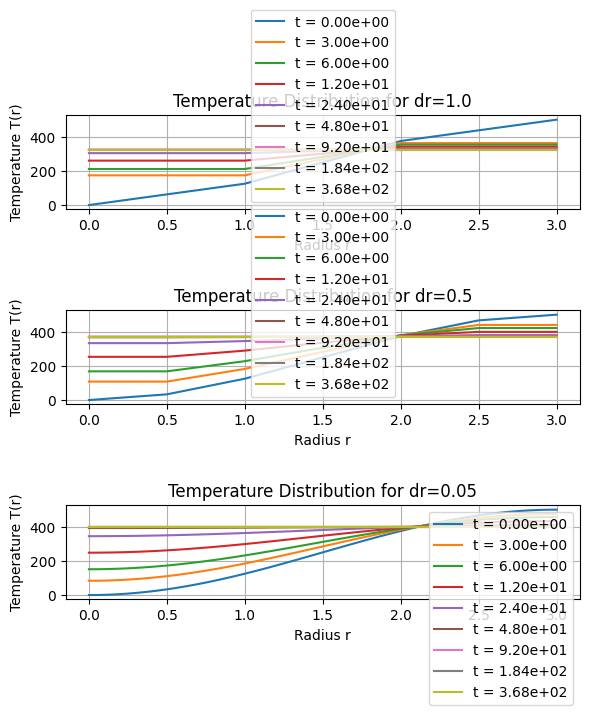

Maximum stable dt is approximately: 333.33333


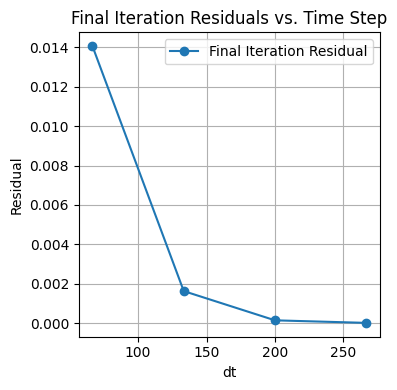

<ipython-input-1-9af8e9083794>:282: RuntimeWarning: overflow encountered in double_scalars
  T_new[i] = T[i] + alpha * dt / dr**2 * (T[i+1] - 2*T[i] + T[i-1]) + alpha * dt / (r[i]*dr) * (T[i+1] - T[i-1])
<ipython-input-1-9af8e9083794>:282: RuntimeWarning: invalid value encountered in double_scalars
  T_new[i] = T[i] + alpha * dt / dr**2 * (T[i+1] - 2*T[i] + T[i-1]) + alpha * dt / (r[i]*dr) * (T[i+1] - T[i-1])


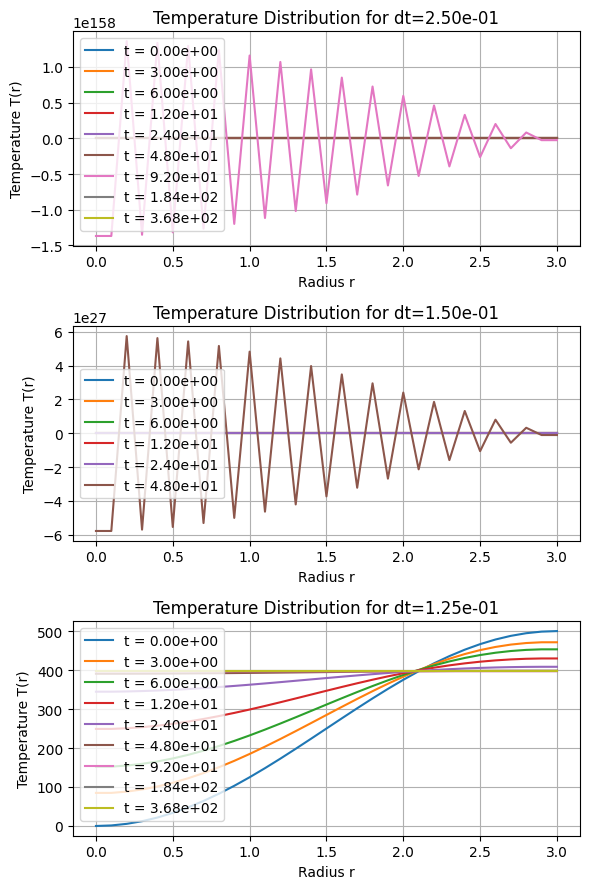

<ipython-input-1-9af8e9083794>:142: RuntimeWarning: invalid value encountered in divide
  temperature += an * np.where(r == 0, lam_n, np.sin(lam_n * r) / r) * np.exp(-alpha * lam_n**2 * t)


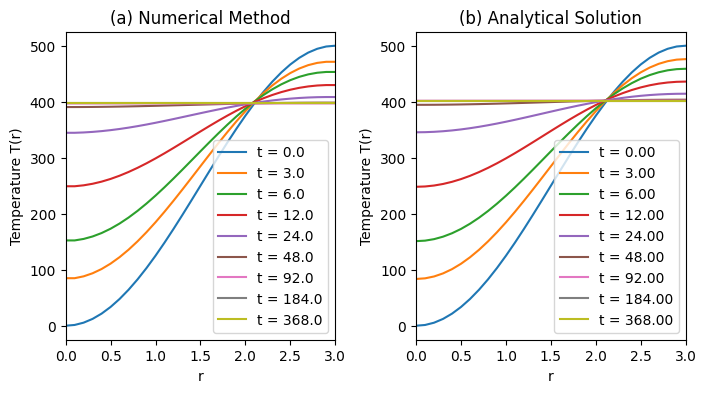

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq


# We begin by defining our Temprature Distribution at Intial Condition in a Solid Sphere

# def temperature_distribution(r, R, T_0, t):
#    if t == 0:
#        return T_0 / 2 * (1 - math.cos(math.pi * r / R))

# According to the problem Statment, we are given the following

# Given values
R = 3       # cm
rho = 8000  # kg/m^3
Cp = 500   # J/kg.K
k = 15     # W/m.K

# Calculate alpha in m^2/s
alpha_m = k / (rho * Cp)

# Convert alpha to cm^2/s
alpha = alpha_m * 10**4

T0 = 500
r_values = np.linspace(0.001, R, 500)
time_values = [0, 3, 6, 12, 24, 48, 92, 184, 368]

print('final temperature = ', 0.5 + 3/(np.pi**2), 'T0')

# The function above will show how the final temprature will be approximately 0.8 T0

# Define the function whose roots we want to find
def func(lambda_val, R):
    return lambda_val * R * np.cos(lambda_val * R) - np.sin(lambda_val * R)

# Search for sign changes in the function over a dense grid
lambda_vals = np.linspace(0, 20, 10000)  # Adjust range and density as needed
func_values = [func(val, R) for val in lambda_vals]

bracket_intervals = []
for i in range(1, len(func_values)):
    if func_values[i-1] * func_values[i] < 0:
        bracket_intervals.append((lambda_vals[i-1], lambda_vals[i]))

# Find the roots using the brackets obtained
eigenvalues = []
for bracket in bracket_intervals:
    try:
        root = brentq(func, bracket[0], bracket[1], args=(R))
        eigenvalues.append(root)
    except ValueError:
        pass

# Ensure uniqueness and sort eigenvalues
eigenvalues = sorted(set(eigenvalues))

# Print the eigenvalues
print("The eigenvalues are:")
for lambda_val in eigenvalues:
    print(f"lambda = {lambda_val:.5f}")


# Plot the function to visualize the roots
plt.plot(lambda_vals, func_values, label=r'$\tan(\lambda R) - \lambda R$')
plt.plot(eigenvalues, [0]*len(eigenvalues), 'bx', label='Eigenvalues')  # Roots
plt.ylim(-60, 60)  # Limit y-axis to avoid extreme values
plt.legend()
plt.xlabel('lambda')
plt.ylabel('lambda * R * cos(lambda * R) - sin(lambda * R)')
plt.title('Eigenvalues Estimation for R = ' + str(R))
plt.grid(True)
plt.show()

def compute_Nn_square(lam_n):
    """Compute the normalization factor N_n^2."""
    r = np.linspace(1e-9, R, 500)
    integrand = (np.sin(lam_n * r) / r)**2 * r**2
    return np.trapz(integrand, r)

def compute_an(lam_n):
    """Compute the normalized coefficient a_n."""
    r = np.linspace(1e-9, R, 500)
    T_initial = (T0 / 2) * (1 - np.cos(np.pi * r / R))
    Nn_square = compute_Nn_square(lam_n)
    integrand = T_initial * (np.sin(lam_n * r) / r) * r**2
    return np.trapz(integrand, r) / Nn_square

def T_final():
    """Compute the steady-state temperature."""
    return 0.5 * T0 + (3 * T0) / np.pi**2

def T_rt(r, t):
    """Compute the temperature distribution T(r,t)."""
    temperature = np.zeros_like(r) + T_final()
    for lam_n in eigenvalues:
        an = compute_an(lam_n)
        temperature += an * np.where(r == 0, lam_n, np.sin(lam_n * r) / r) * np.exp(-alpha * lam_n**2 * t)
    return temperature


def estimate_terms_by_error(r, R, T0, alpha, eigenvalues, time_values, threshold=1e-3):
    """Estimate number of terms for convergence using the Error Estimation method to acquire the number of eigenvalues at different time periods."""
    num_terms_required = []

    for t in time_values:
        prev_temperature = np.zeros_like(r) + T_final()
        converged = False
        for i, lam_n in enumerate(eigenvalues):
            an = compute_an(lam_n)  # Using the existing compute_an function
            # Compute current temperature profile with i terms
            current_temperature = prev_temperature + an * (np.sin(lam_n * r) / r) * np.exp(-alpha * lam_n**2 * t)

            # Compare with previous profile
            error = np.max(np.abs(current_temperature - prev_temperature))
            if error < threshold:
                converged = True
                num_terms_required.append(i + 1)  # Adding 1 because indices start from 0
                break

            prev_temperature = current_temperature

        # If not converged for any eigenvalue
        if not converged:
            num_terms_required.append(len(eigenvalues))

    return num_terms_required

# Test the function
num_terms = estimate_terms_by_error(r_values, R, T0, alpha, eigenvalues, time_values)
print(num_terms)

def T_rt_subset(r, t, R, T0, alpha, eigenvalues):
    """Compute the temperature distribution T(r,t) using a subset of eigenvalues."""
    temperature = np.zeros_like(r) + T_final()
    for lam_n in eigenvalues:
        an = compute_an(lam_n)  # Using the existing compute_an function
        temperature += an * np.where(r == 0, lam_n, np.sin(lam_n * r) / r) * np.exp(-alpha * lam_n**2 * t)
    return temperature

# Estimate the number of terms required for convergence for the time values

fig, ax = plt.subplots(3,3, figsize=(14,9))
plt.subplots_adjust(wspace=0.3, hspace=0.45)
axes = ax.flatten()

flags = [
    [1, 3, 6, 9, 12, 15, 18],
    [1, 3, 5, 7],
    [1, 2, 4, 6],
    [1, 2, 4],
    [1, 2, 3],
    [1, 2],
    [1, 2],
    [1],
    [1]
]

for idx, (current_ax, current_flag) in enumerate(zip(axes, flags)):
    for f in current_flag:
        current_ax.plot(r_values, T_rt_subset(r_values, time_values[idx], R, T0, alpha, eigenvalues[:f]), label='# terms: ' + str(f))
    current_ax.legend(fontsize=6.5, loc=4)
    current_ax.set_xlabel('radius (cm)')
    current_ax.set_title('t = ' + str(time_values[idx]))
    current_ax.set_xlim(0, R)
    current_ax.set_ylim(-30, 510)




plt.show()

# Report the summary for all cases in a table.

# Create a DataFrame
report = pd.DataFrame()
report['Time'] = time_values
report['Eigenvalues'] = num_terms

report

# Display the DataFrame
print(report)

fig, ax = plt.subplots(1,1, figsize=(5,5))


for t in time_values:
    ax.plot(r_values, T_rt_subset(r_values, t, R, T0, alpha, eigenvalues), label=f't = {t:.2f}')

ax.set_title("Converged Temperature Distribution $T(r, t_{i})$ form $t_0$ to $t_6$ and steady state")
ax.set_xlabel("Radius $r$")
ax.set_ylabel("Temperature $T(r, t_{i})$")
ax.legend()
ax.grid(True)
ax.set_xlim(0, R)
plt.show()

# List of eigenvalues
eigenvalues = [
    1.49780, 2.57508, 3.63471, 4.68873, 5.74025,
    6.79043, 7.83982, 8.88868, 9.93720, 10.98546,
    12.03354, 13.08148, 14.12930, 15.17704, 16.22471,
    17.27233, 18.31989, 19.36742
]

# Create a DataFrame
eigenvalues_df = pd.DataFrame(eigenvalues, columns=['Eigenvalues'])

# Print the DataFrame
print(eigenvalues_df)

# Comment on the convergence properties of the analytical solution (impact of the number of terms needed for convergence).

# The analytical solution reveals intriguing dynamics in terms of convergence. The convergence of the series solution is intricately tied to the rate at which transient terms decay over time, a phenomenon explored in detail in Part (II). Notably, the number of modes (series terms) required for convergence exhibits a dynamic behavior over time. An interesting observation emerges: as time progresses, the demand for a higher number of modes for reasonable convergence diminishes. This trend is visually apparent, with curves at higher time values showing similarity even when fewer modes are employed. This phenomenon aligns with the notion that the transient terms decay rapidly, contributing to a convergence toward a steady-state solution. The implications become more pronounced as we consider the behavior as time approaches infinity. The temperature profile tends to a steady-state distribution, and the rapid decay of higher modes ensures that the steady-state solution is predominantly dictated by the lowest mode. This consistency with the observation that the number of modes required for convergence decreases as we approach the steady-state enhances our understanding of the convergence properties. In summary, the series solution not only captures the transient dynamics effectively but also reveals a dynamic relationship between time, modes, and convergence. The diminishing influence of higher modes over time and their eventual subservience to the lowest mode underscore the intricate interplay within the analytical solution.


# Numerical Solution
# Gauss Seidel Study to determine the proper values of dt for the solution
def gauss_seidel(T_initial, alpha, dr, dt, r, max_iter=5000, tol=1e-6):
    N = len(T_initial)
    T_new = T_initial.copy()

    for iteration in range(max_iter):
        T_old = T_new.copy()

        for i in range(1, N-1):
            T_new[i] = T_old[i] + alpha * dt / dr**2 * (T_old[i+1] - 2*T_old[i] + T_old[i-1]) + alpha * dt / (r[i]*dr) * (T_old[i+1] - T_old[i-1])

        # Boundary conditions
        T_new[0] = T_new[1]
        T_new[-1] = T_new[-2]

        # Check convergence
        if np.linalg.norm(T_new - T_old, np.inf) < tol:
            break

    return np.linalg.norm(T_new - T_old, np.inf)

# Parameters
R_value = R
T0_value = T0
alpha_value = alpha_m

# search following \Delta r values
dr_values = [1.0, 0.5, 0.25, 0.125, 0.10, 0.09, 0.08, 0.07, 0.06, 0.05, 0.01]

dt = 1e-4

residuals = []
for dr in dr_values:
    r_current = np.arange(0, R_value + dr, dr)
    T_initial = T0_value/2 * (1 - np.cos(np.pi * r_current / R_value))
    residual = gauss_seidel(T_initial, alpha_value, dr, dt, r_current)
    residuals.append(residual)

# Plotting the residuals vs dr
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(dr_values, residuals, 'o-', label="Residual")
ax.set_xlabel('dr')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs. dr')
plt.legend()
plt.grid(True)
plt.show()

# Now, solve the problem numerically using a finite difference scheme (central difference for space, and explicit in time).

def initialize_temperature(r, R, T0):
    """Initial temperature distribution."""
    return T0/2 * (1 - np.cos(np.pi * r / R))

def explicit_method(T, alpha, dr, dt, r):
    N = len(T)
    T_new = T.copy()

    for i in range(1, N-1):
        T_new[i] = T[i] + alpha * dt / dr**2 * (T[i+1] - 2*T[i] + T[i-1]) + alpha * dt / (r[i]*dr) * (T[i+1] - T[i-1])

    # Boundary conditions
    T_new[0] = T_new[1]
    T_new[-1] = T_new[-2]

    return T_new

def solve_heat_equation_explicit(R, T0, alpha, dr, dt, max_time, time_points):
    r = np.arange(0, R + dr, dr)
    T = initialize_temperature(r, R, T0)
    times = np.arange(0, max_time, dt)
    stored_profiles = {}

    for t in times:
        if t in time_points:
            stored_profiles[t] = T.copy()
        T = explicit_method(T, alpha, dr, dt, r)

    return r, stored_profiles

# Parameters
dt = 1e-2
max_time = 400
time_points = time_values
dr_values = [1.0, 0.5, 0.05]
fig, axes = plt.subplots(len(dr_values), 1, figsize=(6, 2*len(dr_values)))

for idx, dr in enumerate(dr_values):
    r_values, stored_profiles = solve_heat_equation_explicit(R, T0, alpha, dr, dt, max_time, time_points)

    # Plotting the temperature distribution for the stored time points
    for t, T in stored_profiles.items():
        axes[idx].plot(r_values, T, '-', label=f't = {t:.2e}')
        axes[idx].set_xlabel('Radius r')
        axes[idx].set_ylabel('Temperature T(r)')
        axes[idx].set_title(f'Temperature Distribution for dr={dr}')
        axes[idx].grid(True)
        axes[idx].legend()

plt.tight_layout()
plt.show()

# Gauss Seidel Study to determine the proper values of dt for the solution
def gauss_seidel(T_initial, alpha, dr, dt, r, max_iter=5000, tol=1e-6):
    N = len(T_initial)
    T_new = T_initial.copy()

    for iteration in range(max_iter):
        T_old = T_new.copy()

        for i in range(1, N-1):
            T_new[i] = T_old[i] + alpha * dt / dr**2 * (T_old[i+1] - 2*T_old[i] + T_old[i-1]) + alpha * dt / (r[i]*dr) * (T_old[i+1] - T_old[i-1])

        # Boundary conditions
        T_new[0] = T_new[1]
        T_new[-1] = T_new[-2]

        # Compute residual and check for convergence
        residual = np.linalg.norm(T_new - T_old, np.inf)
        if residual < tol:
            break

    return residual

# Parameters
R_value = R
T0_value = T0
alpha_value = alpha_m
dr = 0.05
stability_limit = 0.5 * dr**2 / alpha_value
print(f"Maximum stable dt is approximately: {stability_limit:.5f}")

dt_values = [stability_limit * 0.8, stability_limit * 0.6, stability_limit * 0.4, stability_limit * 0.2]

final_residuals = []
for dt in dt_values:
    r_current = np.arange(0, R_value + dr, dr)
    T_initial = T0_value/2 * (1 - np.cos(np.pi * r_current / R_value))
    residual = gauss_seidel(T_initial, alpha_value, dr, dt, r_current)
    final_residuals.append(residual)

# Plotting the final iteration residuals
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(dt_values, final_residuals, 'o-', label="Final Iteration Residual")
ax.set_xlabel('dt')
ax.set_ylabel('Residual')
ax.set_title('Final Iteration Residuals vs. Time Step')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


dt_values = [0.25, 0.15, 0.125,]
fig, axes = plt.subplots(len(dt_values), 1, figsize=(6, 3*len(dt_values)))

# from study (I)
dr = 0.1

for idx, dt in enumerate(dt_values):
    r_values, stored_profiles = solve_heat_equation_explicit(R, T0, alpha, dr, dt, max_time, time_points)

    # Plotting the temperature distribution for the stored time points
    for t, T in stored_profiles.items():
        axes[idx].plot(r_values, T, '-', label=f't = {t:.2e}')
        axes[idx].set_xlabel('Radius r')
        axes[idx].set_ylabel('Temperature T(r)')
        axes[idx].set_title(f'Temperature Distribution for dt={dt:.2e}')
        axes[idx].grid(True)
        axes[idx].legend()

plt.tight_layout()
plt.show()


def explicit_method(T, alpha, dr, dt, r):
    N = len(T)
    T_new = T.copy()

    for i in range(1, N-1):
        T_new[i] = T[i] + alpha * dt / dr**2 * (T[i+1] - 2*T[i] + T[i-1]) + alpha * dt / (r[i]*dr) * (T[i+1] - T[i-1])

    # Boundary conditions
    T_new[0] = T_new[1]
    T_new[-1] = T_new[-2]

    return T_new

def solve_heat_equation_explicit(R, T0, alpha, dr, dt, max_time, time_points):
    r = np.arange(0, R + dr, dr)
    T = initialize_temperature(r, R, T0)
    times = np.arange(0, max_time, dt)
    stored_profiles = {}

    for t in times:
        if t in time_points:
            stored_profiles[t] = T.copy()
        T = explicit_method(T, alpha, dr, dt, r)

    return r, stored_profiles

# Part (I)
dr = 0.1

# part (II)
dt_values = 0.1

r_values, stored_profiles = solve_heat_equation_explicit(R, T0, alpha, dr, dt, max_time, time_points)
tags = list(stored_profiles.keys())

fig, ax = plt.subplots(1,2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.3)

# Plotting
for t, profile in stored_profiles.items():
    ax[0].plot(r_values, profile, label=f't = {t}')
ax[0].set_xlabel('r')
ax[0].set_ylabel('Temperature T(r)')
ax[0].set_title('(a) Numerical Method')
ax[0].set_xlim(0, R)
ax[0].legend()


for t in time_values:
    ax[1].plot(r_values, T_rt_subset(r_values, t, R, T0, alpha, eigenvalues), label=f't = {t:.2f}')


ax[1].legend()
ax[1].set_xlabel('r')
ax[1].set_ylabel('Temperature T(r)')
ax[1].set_title('(b) Analytical Solution')
ax[1].set_xlim(0, R)
plt.show()